In [1]:
using MomentClosure, Catalyst, Latexify, OrdinaryDiffEq

In [2]:
@parameters t, k_on, k_off, k_p, γ_p, b
@variables p(t), g(t)

vars = [g, p]

ps = [k_on, k_off, k_p, γ_p, b]

S = [1 -1 0 0; 
     0 0 b -1]

# G* -> G : 0 -> g 
# G -> G* : g -> 0
# g = 1 (G) or 0 (G*)

as = [k_on*(1-g),    # 0 -> g
      k_off*g*(p^2), # g -> 0
      k_p*g,         # 0 -> mP, m ~ Geometric(mean=b) 
      γ_p*p]         # p -> 0

binary_vars = [1]

rn = ReactionSystemMod(t, vars, ps, as, S)

ReactionSystemMod(t, Term{Real, Base.ImmutableDict{DataType, Any}}[g(t), p(t)], Sym{Real, Base.ImmutableDict{DataType, Any}}[k_on, k_off, k_p, γ_p, b], SymbolicUtils.Mul{Real, Int64, Dict{Any, Number}, Nothing}[k_on*(1 - g(t)), k_off*(p(t)^2)*g(t), k_p*g(t), γ_p*p(t)], Any[1 -1 0 0; 0 0 b -1], Symbol("##ReactionSystemMod#291"))

In [3]:
raw_eqs = generate_raw_moment_eqs(rn, 3)
closed_raw_eqs = moment_closure(raw_eqs, "conditional derivative matching", binary_vars)
latexify(closed_raw_eqs)

"\\begin{align*}\n\\frac{d\\mu{_{10}}}{dt} =& k_{on} - k_{on} \\mu{_{10}} - k_{off} \\mu{_{12}} \\\\\n\\frac{d\\mu{_{01}}}{dt} =& b k_{p} \\mu{_{10}} - \\gamma_{p} \\mu{_{01}} \\\\\n\\frac{d\\mu{_{11}}}{dt} =& k_{on} \\mu{_{01}} + b k_{p} \\mu{_{10}} - k_{on} \\mu{_{11}} - \\gamma_{p} \\mu{_{11}" ⋯ 440 bytes ⋯ "}^{6} \\\\\n\\frac{d\\mu{_{03}}}{dt} =& b k_{p} \\mu{_{10}} + 3 \\gamma_{p} \\mu{_{02}} + 6 k_{p} b^{2} \\mu{_{10}} + 6 k_{p} b^{3} \\mu{_{10}} + 3 b k_{p} \\mu{_{11}} + 3 b k_{p} \\mu{_{12}} + 6 k_{p} b^{2} \\mu{_{11}} - \\gamma_{p} \\mu{_{01}} - 3 \\gamma_{p} \\mu{_{03}}\n\\end{align*}\n"

Notation: $\mu_{03} =\langle n_2^3 \rangle$, $\mu_{12} = \langle n_1 n_2^2 \rangle$

In [4]:
latexify(closed_raw_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& \mu{_{11}}^{-3} \mu{_{12}}^{3} \mu{_{10}} \\
\mu{_{14}} =& \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4}
\end{align*}
"

In [5]:
# PARAMETER INITIALISATION
mean_p = 200
mean_b = 70
γ_p_val = 1
k_off_val = 0.001
k_on_val = 0.05

k_p_val = mean_p * γ_p_val * (k_off_val * mean_p^2 + k_on_val) / (k_on_val * mean_b)

pmap = [k_on => k_on_val,
        k_off => k_off_val,
        k_p => k_p_val,
        γ_p => γ_p_val,
        b => mean_b]

# DETERMINISTIC INITIAL CONDITIONS

μ₀ = [1, 1]
u₀map = deterministic_IC(μ₀, closed_raw_eqs)

# time interval to solve on
tspan = (0., 6.0)
dt = 0.01

@time oprob = ODEProblem(closed_raw_eqs, u₀map, tspan, pmap);
@time sol_raw = solve(oprob, Tsit5(), saveat=dt);

 40.757608 seconds (28.93 M allocations: 1.721 GiB, 3.29% gc time, 99.68% compilation time)
  8.135399 seconds (4.72 M allocations: 259.490 MiB, 2.37% gc time, 99.75% compilation time)


In [6]:
central_eqs = generate_central_moment_eqs(rn, 3)
closed_central_eqs = moment_closure(central_eqs, "conditional derivative matching", binary_vars)
latexify(closed_central_eqs, env=:mdtable)

|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  $\frac{d\mu{_{10}}}{dt} = k_{on} - k_{off} M{_{12}} - k_{on} \mu{_{10}} - \frac{2}{1} k_{off} M{_{11}} \mu{_{01}} - k_{off} \mu{_{01}}^{2} \mu{_{10}} - k_{off} M{_{02}} \mu{_{10}}$ |
| -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 $\frac{d\mu{_{01}}}{dt} = b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}}$ |
|                                                                                                                                                                                                                                                                                                                                                                                                           $\frac{dM{_{11}}}{dt} = b k_{p} \mu{_{10}} + k_{off} \mu{_{01}}^{3} \mu{_{10}} + k_{off} M{_{12}} \mu{_{01}} + 2 k_{off} \mu{_{01}}^{2} M{_{11}} + k_{off} M{_{02}} \mu{_{01}} \mu{_{10}} - k_{on} M{_{11}} - \gamma_{p} M{_{11}} - b k_{p} \mu{_{10}}^{2} - k_{off} \left( \mu{_{01}} \mu{_{10}} + M{_{11}} \right)^{-3} \left( \mu{_{01}}^{2} \mu{_{10}} + M{_{02}} \mu{_{10}} + 2 M{_{11}} \mu{_{01}} + M{_{12}} \right)^{3} \mu{_{10}}$ |
|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           $\frac{dM{_{02}}}{dt} = \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 b k_{p} M{_{11}} + 2 k_{p} b^{2} \mu{_{10}} - 2 \gamma_{p} M{_{02}}$ |
| $\frac{dM{_{12}}}{dt} = \gamma_{p} M{_{11}} + k_{off} M{_{02}} M{_{12}} + b k_{p} \mu{_{10}} + k_{off} M{_{02}}^{2} \mu{_{10}} + 2 b k_{p} M{_{11}} + 2 k_{p} b^{2} \mu{_{10}} + 2 k_{off} M{_{02}} M{_{11}} \mu{_{01}} + 2 k_{off} \left( \mu{_{01}} \mu{_{10}} + M{_{11}} \right)^{-3} \left( \mu{_{01}}^{2} \mu{_{10}} + M{_{02}} \mu{_{10}} + 2 M{_{11}} \mu{_{01}} + M{_{12}} \right)^{3} \mu{_{01}} \mu{_{10}} - k_{on} M{_{12}} - 2 \gamma_{p} M{_{12}} - b k_{p} \mu{_{10}}^{2} - 2 k_{p} b^{2} \mu{_{10}}^{2} - k_{off} \mu{_{01}}^{2} M{_{12}} - k_{off} \mu{_{01}}^{4} \mu{_{10}} - 2 k_{off} \mu{_{01}}^{3} M{_{11}} - k_{off} \left( \mu{_{01}} \mu{_{10}} + M{_{11}} \right)^{-8} \left( \mu{_{01}}^{2} \mu{_{10}} + M{_{02}} \mu{_{10}} + 2 M{_{11}} \mu{_{01}} + M{_{12}} \right)^{6} \mu{_{10}}^{3} - 4 b k_{p} M{_{11}} \mu{_{10}}$ |
|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          $\frac{dM{_{03}}}{dt} = b k_{p} \mu{_{10}} + 3 \gamma_{p} M{_{02}} + 3 b k_{p} M{_{11}} + 6 k_{p} b^{2} M{_{11}} + 3 b k_{p} M{_{12}} + 6 k_{p} b^{2} \mu{_{10}} + 6 k_{p} b^{3} \mu{_{10}} - \gamma_{p} \mu{_{01}} - 3 \gamma_{p} M{_{03}}$ |


In [7]:
latexify(closed_central_eqs)

"\\begin{align*}\n\\frac{d\\mu{_{10}}}{dt} =& k_{on} - k_{off} M{_{12}} - k_{on} \\mu{_{10}} - \\frac{2}{1} k_{off} M{_{11}} \\mu{_{01}} - k_{off} \\mu{_{01}}^{2} \\mu{_{10}} - k_{off} M{_{02}} \\mu{_{10}} \\\\\n\\frac{d\\mu{_{01}}}{dt} =& b k_{p} \\mu{_{10}} - \\gamma_{p} \\mu{_{01}} \\\\\n" ⋯ 1375 bytes ⋯ "_{11}} \\mu{_{10}} \\\\\n\\frac{dM{_{03}}}{dt} =& b k_{p} \\mu{_{10}} + 3 \\gamma_{p} M{_{02}} + 3 b k_{p} M{_{11}} + 6 k_{p} b^{2} M{_{11}} + 3 b k_{p} M{_{12}} + 6 k_{p} b^{2} \\mu{_{10}} + 6 k_{p} b^{3} \\mu{_{10}} - \\gamma_{p} \\mu{_{01}} - 3 \\gamma_{p} M{_{03}}\n\\end{align*}\n"

In [8]:
u₀map = deterministic_IC(μ₀, closed_central_eqs)

@time oprob = ODEProblem(closed_central_eqs, u₀map, tspan, pmap);
@time sol_central = solve(oprob, Tsit5(), saveat=dt);

  6.340701 seconds (2.29 M allocations: 139.296 MiB, 1.46% gc time, 99.23% compilation time)
 13.443815 seconds (2.12 M allocations: 117.953 MiB, 0.71% gc time, 99.89% compilation time)


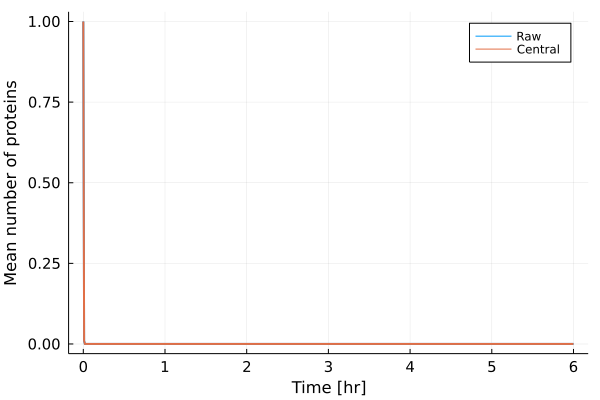

In [9]:
using Plots
plot(sol_central.t, [sol_raw[1,:], sol_central[1,:]], 
    label  = ["Raw" "Central"], 
    legend = true,
    xlabel = "Time [hr]",
    ylabel = "Mean number of proteins",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

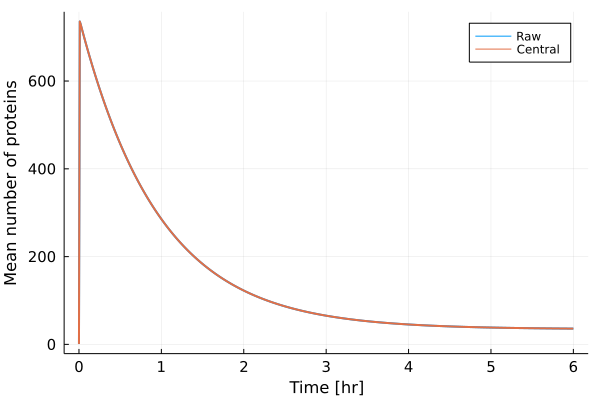

In [10]:
plot(sol_central.t, [sol_raw[2,:], sol_central[2,:]], 
    label  = ["Raw" "Central"], 
    legend = true,
    xlabel = "Time [hr]",
    ylabel = "Mean number of proteins",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

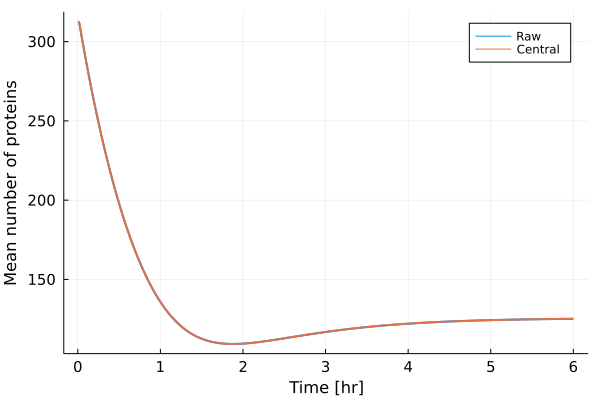

In [11]:
raw_std = sqrt.(sol_raw[4,2:end] .- sol_raw[2,2:end].^2)
central_std = sqrt.(sol_central[4,2:end])
plot(sol_central.t[2:end], [raw_std, central_std], 
    label  = ["Raw" "Central"], 
    legend = true,
    xlabel = "Time [hr]",
    ylabel = "Mean number of proteins",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)